In [61]:
# Land Cover classification project
# The aim of the project is to build a deep learning model enable to classify a satellite image between 10 category.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tarfile

In [3]:
#Loading the dataset
#!python -m wget https://cerfacs.fr/opendata/cours/data/TRAIN.tar
#!python -m wget https://cerfacs.fr/opendata/cours/data/y_train.npy

In [4]:
# Loading the dataset
def extract_files(dataset):
  tar = tarfile.open(dataset+'.tar', 'r')
  names = tar.getmembers()[:]
  images = [tar.extractfile(name) for name in names]

  return (np.array([np.array(Image.open(image)) for image in images]))

X_train_raw = extract_files('TRAIN')
y_train_raw = np.load('y_train.npy')

In [5]:
N_classes = len(np.unique(y_train_raw))
print("Number of classes :", N_classes)

Number of classes : 10


<AxesSubplot:ylabel='count'>

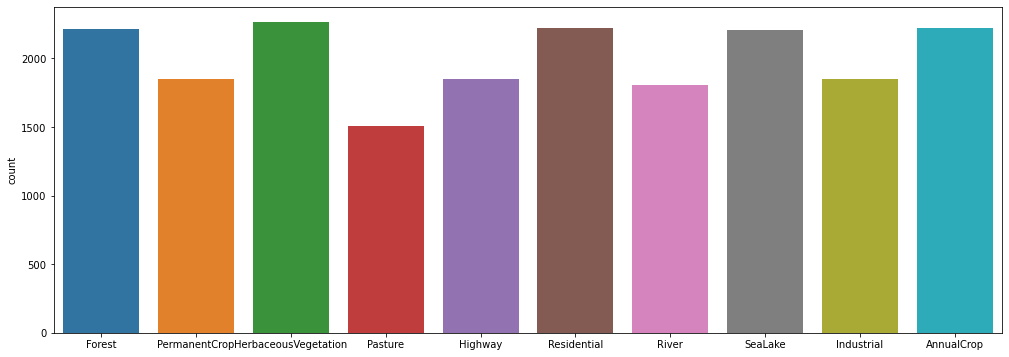

In [6]:
# Classes are equally distributed
plt.figure(figsize=(17,6))
sns.countplot(x=y_train_raw)

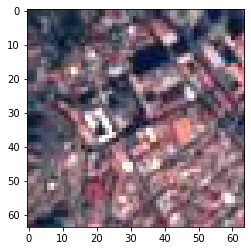

In [7]:
plt.imshow(X_train_raw[7])

In [8]:
# (One Hot) encoding the target
encoder = LabelBinarizer()
y_train_raw = encoder.fit_transform(y_train_raw)

In [9]:
# Creating train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, test_size=0.20, shuffle=True)
# Dividing the train dataset in train/validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)

In [21]:
# Creation of tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

Metal device set to: Apple M1


2022-10-31 17:45:02.348389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 17:45:02.348701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# Configuring the datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
initial_learning_rate = 1e-3

In [29]:
N_epochs = 10

In [30]:
# Importing Resnet Model without weights
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(64, 64, 3),
    classes=N_classes)

In [31]:
inputs = tf.keras.layers.Input(shape=(64, 64, 3), dtype=tf.uint8)
x = tf.keras.layers.Rescaling(1./255)(inputs)
outputs = resnet_model(inputs)
resnet_without_weights = tf.keras.Model(inputs, outputs)
resnet_without_weights.compile(tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy'])

In [32]:
history = resnet_without_weights.fit(train_ds, validation_data = val_ds, epochs = N_epochs - 5)

Epoch 1/5


2022-10-31 17:45:52.842888: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-31 17:45:52.843212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 1.9884 - accuracy: 0.4464

2022-10-31 17:46:53.241757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 68s 158ms/step - loss: 1.9884 - accuracy: 0.4464 - val_loss: 2.6982 - val_accuracy: 0.3635
Epoch 2/5
375/375 [==============================] - 58s 156ms/step - loss: 1.3381 - accuracy: 0.5703 - val_loss: 14.0705 - val_accuracy: 0.1483
Epoch 3/5
375/375 [==============================] - 58s 155ms/step - loss: 1.0830 - accuracy: 0.6279 - val_loss: 1.5599 - val_accuracy: 0.5073
Epoch 4/5
375/375 [==============================] - 59s 156ms/step - loss: 0.9797 - accuracy: 0.6691 - val_loss: 8.3471 - val_accuracy: 0.3038
Epoch 5/5
375/375 [==============================] - 58s 156ms/step - loss: 0.9035 - accuracy: 0.6890 - val_loss: 0.8645 - val_accuracy: 0.6885


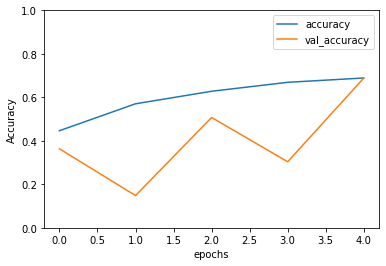

In [33]:
# There is overfitting
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.legend()

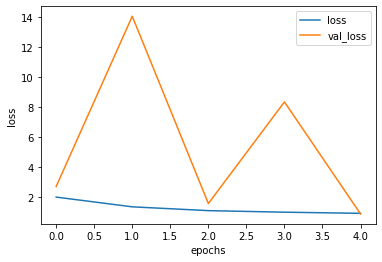

In [34]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()

In [35]:
# Use of Data augmentation to increase scores and reduce overfitting
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [36]:
train_ds_data_aug = train_datagen.flow(X_train, y_train, batch_size=32)
val_ds_data_aug = train_datagen.flow(X_val, y_val, batch_size=32)

In [37]:
history_2 = resnet_without_weights.fit(train_ds_data_aug, validation_data=val_ds_data_aug, epochs=N_epochs-5)

Epoch 1/5


2022-10-31 17:51:19.147511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 1.0077 - accuracy: 0.6599

2022-10-31 17:52:15.712636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 63s 161ms/step - loss: 1.0077 - accuracy: 0.6599 - val_loss: 2.4139 - val_accuracy: 0.5375
Epoch 2/5
375/375 [==============================] - 60s 160ms/step - loss: 1.3937 - accuracy: 0.5633 - val_loss: 15.0245 - val_accuracy: 0.3935
Epoch 3/5
375/375 [==============================] - 62s 164ms/step - loss: 1.2228 - accuracy: 0.5993 - val_loss: 1.9962 - val_accuracy: 0.6035
Epoch 4/5
375/375 [==============================] - 62s 167ms/step - loss: 1.0625 - accuracy: 0.6409 - val_loss: 17.7118 - val_accuracy: 0.4910
Epoch 5/5
375/375 [==============================] - 62s 166ms/step - loss: 1.0107 - accuracy: 0.6673 - val_loss: 1339.5474 - val_accuracy: 0.1200


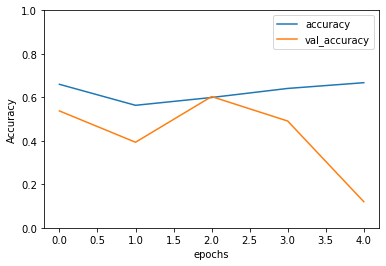

In [38]:
# There is still overfitting
plt.plot(history_2.history["accuracy"], label="accuracy")
plt.plot(history_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.legend()

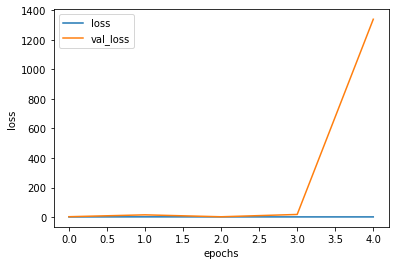

In [40]:
plt.plot(history_2.history["loss"], label="loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()

In [42]:
# Using Resnet50 model, pre-trained on imagenet dataset
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
     weights='imagenet',
    input_shape=(64,64,3),
    )
# Freezing the convolutional base to not update weights learned 
base_model.trainable = False   

inputs = tf.keras.layers.Input(shape=(64, 64, 3), dtype=tf.uint8)
# Normalization of the input data using the mean and variance of imagenet dataset
x = tf.keras.layers.Normalization(
    axis=-1, 
    mean=[0.485, 0.456, 0.406], 
    variance=[0.229, 0.224, 0.225])(inputs)
# See this to explain the training=false : https://www.tensorflow.org/tutorials/images/transfer_learning#freeze_the_convolutional_base 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512)(x)
outputs = tf.keras.layers.Dense(N_classes, activation='softmax')(x)
resnet_imagenet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [43]:
resnet_imagenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
history_3 = resnet_imagenet_model.fit(train_ds_data_aug, validation_data= val_ds_data_aug, epochs=N_epochs) 

Epoch 1/10


2022-10-31 17:59:45.478796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 2.1320 - accuracy: 0.7247

2022-10-31 18:00:02.572269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 24s 58ms/step - loss: 2.1320 - accuracy: 0.7247 - val_loss: 1.7699 - val_accuracy: 0.7400
Epoch 2/10
375/375 [==============================] - 21s 55ms/step - loss: 1.0292 - accuracy: 0.8024 - val_loss: 0.7181 - val_accuracy: 0.8270
Epoch 3/10
375/375 [==============================] - 21s 55ms/step - loss: 0.5923 - accuracy: 0.8357 - val_loss: 0.5499 - val_accuracy: 0.8455
Epoch 4/10
375/375 [==============================] - 21s 56ms/step - loss: 0.5014 - accuracy: 0.8492 - val_loss: 0.4575 - val_accuracy: 0.8538
Epoch 5/10
375/375 [==============================] - 21s 55ms/step - loss: 0.4505 - accuracy: 0.8500 - val_loss: 0.4948 - val_accuracy: 0.8443
Epoch 6/10
375/375 [==============================] - 21s 56ms/step - loss: 0.4433 - accuracy: 0.8517 - val_loss: 0.4507 - val_accuracy: 0.8495
Epoch 7/10
375/375 [==============================] - 21s 57ms/step - loss: 0.4332 - accuracy: 0.8536 - val_loss: 0.4767 - val_accuracy: 0.8450
Epo

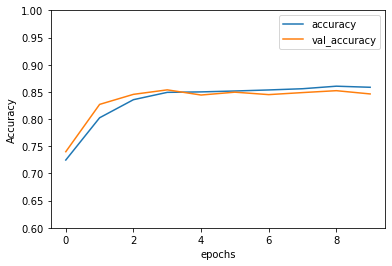

In [44]:
plt.plot(history_3.history["accuracy"], label="accuracy")
plt.plot(history_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.legend()

In [45]:
# Fine tuning to improve performance
base_model.trainable = True

# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [46]:
# Fine-tune from this layer onwards
fine_tune_start = 130
# Freezing all the layers before
for layer in base_model.layers[0:fine_tune_start]:
  layer.trainable = False

In [47]:
resnet_imagenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate/10), loss='categorical_crossentropy',metrics=['accuracy'])
fine_tune_epochs = 5
history_fine_tune = resnet_imagenet_model.fit(train_ds_data_aug,
                                              validation_data= val_ds_data_aug,
                                              initial_epoch=history_3.epoch[-1],
                                              epochs=N_epochs + fine_tune_epochs)

Epoch 10/15


2022-10-31 18:04:30.872487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8657

2022-10-31 18:05:00.855730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 37s 91ms/step - loss: 0.3951 - accuracy: 0.8657 - val_loss: 0.3931 - val_accuracy: 0.8688
Epoch 11/15
375/375 [==============================] - 34s 90ms/step - loss: 0.2826 - accuracy: 0.9050 - val_loss: 0.3019 - val_accuracy: 0.8983
Epoch 12/15
375/375 [==============================] - 33s 89ms/step - loss: 0.2506 - accuracy: 0.9125 - val_loss: 0.2803 - val_accuracy: 0.9075
Epoch 13/15
375/375 [==============================] - 33s 88ms/step - loss: 0.2284 - accuracy: 0.9203 - val_loss: 0.2517 - val_accuracy: 0.9115
Epoch 14/15
375/375 [==============================] - 33s 89ms/step - loss: 0.2089 - accuracy: 0.9284 - val_loss: 0.3244 - val_accuracy: 0.8938
Epoch 15/15
375/375 [==============================] - 33s 89ms/step - loss: 0.2100 - accuracy: 0.9287 - val_loss: 0.2780 - val_accuracy: 0.9105


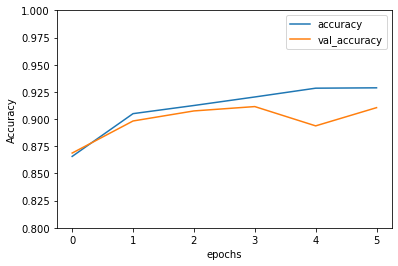

In [49]:
plt.plot(history_fine_tune.history["accuracy"], label="accuracy")
plt.plot(history_fine_tune.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.legend()

In [50]:
resnet_imagenet_model.evaluate(X_test,y_test)

2022-10-31 18:08:32.090235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 6s 40ms/step - loss: 0.2774 - accuracy: 0.9105


[0.2774496078491211, 0.9105000495910645]

In [51]:
# The model built allows to predict the category of an image with an accuracy of ~91%. To achieve this, we tried first to use the resnet50 model with random initials
# weights. Then, we tried some data augmentation to overcome overfitting. It wasn't enought so we used the weights of imagenet dataset with the resnet model. 
# On top of that we add a fully connected layer. Finally, to increase a bit more performance, we tried to fine tuning by unfreezing some layers of 
# the base model to be able to learn also high-level features specific to the dataset. 
# A bigger dataset would provide better results.